In [1]:
import sys
sys.path.insert(0,'../code')

In [2]:
from torchvision.transforms.functional import normalize
from transformers import ViTFeatureExtractor, ViTForImageClassification
from models.interpretation import ImageInterpretationNet
from datamodules.image_classification import CIFAR10DataModule
from datamodules.transformations import UnNest
from attributions.grad_cam import grad_cam
from attributions.attention_rollout import attention_rollout
from matplotlib import pyplot as plt
from utils.plot import smoothen, draw_mask_on_image, draw_heatmap_on_image

/home/angelos/anaconda3/envs/dl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Sample Images and Model

In [3]:
# Load pre-trained Transformer
vit = ViTForImageClassification.from_pretrained("tanlq/vit-base-patch16-224-in21k-finetuned-cifar10")
vit.eval()

# Load images
feature_extractor=ViTFeatureExtractor.from_pretrained(
    "tanlq/vit-base-patch16-224-in21k-finetuned-cifar10", return_tensors="pt"
)
feature_extractor = UnNest(feature_extractor)

dm = CIFAR10DataModule(feature_extractor=feature_extractor, batch_size=800)
dm.prepare_data()
dm.setup()
dt = iter(dm.test_dataloader())
images, labels = next(dt)

indices = [235, 330, 67, 760, 227, 141, 29, 56, 80, 170]

images, labels = images[indices], labels[indices]
rgb_images = [normalize(image, [-0.5, -0.5, -0.5], [2, 2, 2]).permute(1, 2, 0).clip(0, 1) for image in images] 

# Create interpretation model
diffmask = ImageInterpretationNet.load_from_checkpoint('diffmask.ckpt')
diffmask.set_vision_transformer(vit)

Files already downloaded and verified
Files already downloaded and verified


### Visualization Function

In [4]:
draw_mask = lambda image, mask: draw_mask_on_image(image.permute(2, 0, 1), smoothen(mask)).permute(1, 2, 0).clip(0,
                                                                                                             1).numpy()
draw_heatmap = lambda image, mask: draw_heatmap_on_image(image.permute(2, 0, 1), smoothen(mask)).permute(1, 2, 0).clip(
0, 1).numpy()

def visualize(aggregated=True, save=False, name=''):    
    layers = 14
    fig, ax = plt.subplots(layers+1, 10, figsize=(20, 28))

    font_size = 20

    # Remove axes
    for i in range(layers+1):
        for j in range(10):
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])


    ax[0, 0].set_ylabel('Input', fontsize=font_size)
    for i in range(10):
        ax[0, i].imshow(rgb_images[i])        

    font_size = 20
    for j in range(layers):
        ax[j+1, 0].set_ylabel(f'Layer {j}', fontsize=font_size)
        diff_masks = diffmask.get_mask(images, j, aggregated)["mask"].detach()
        for i in range(10):
            ax[j+1, i].imshow(draw_heatmap(rgb_images[i], diff_masks[i].detach()), cmap='hot')

    fig.tight_layout()
    if save:
        fig.savefig(f"{name}.jpg", dpi=300)
    else:
        plt.plot


### Plot Masks

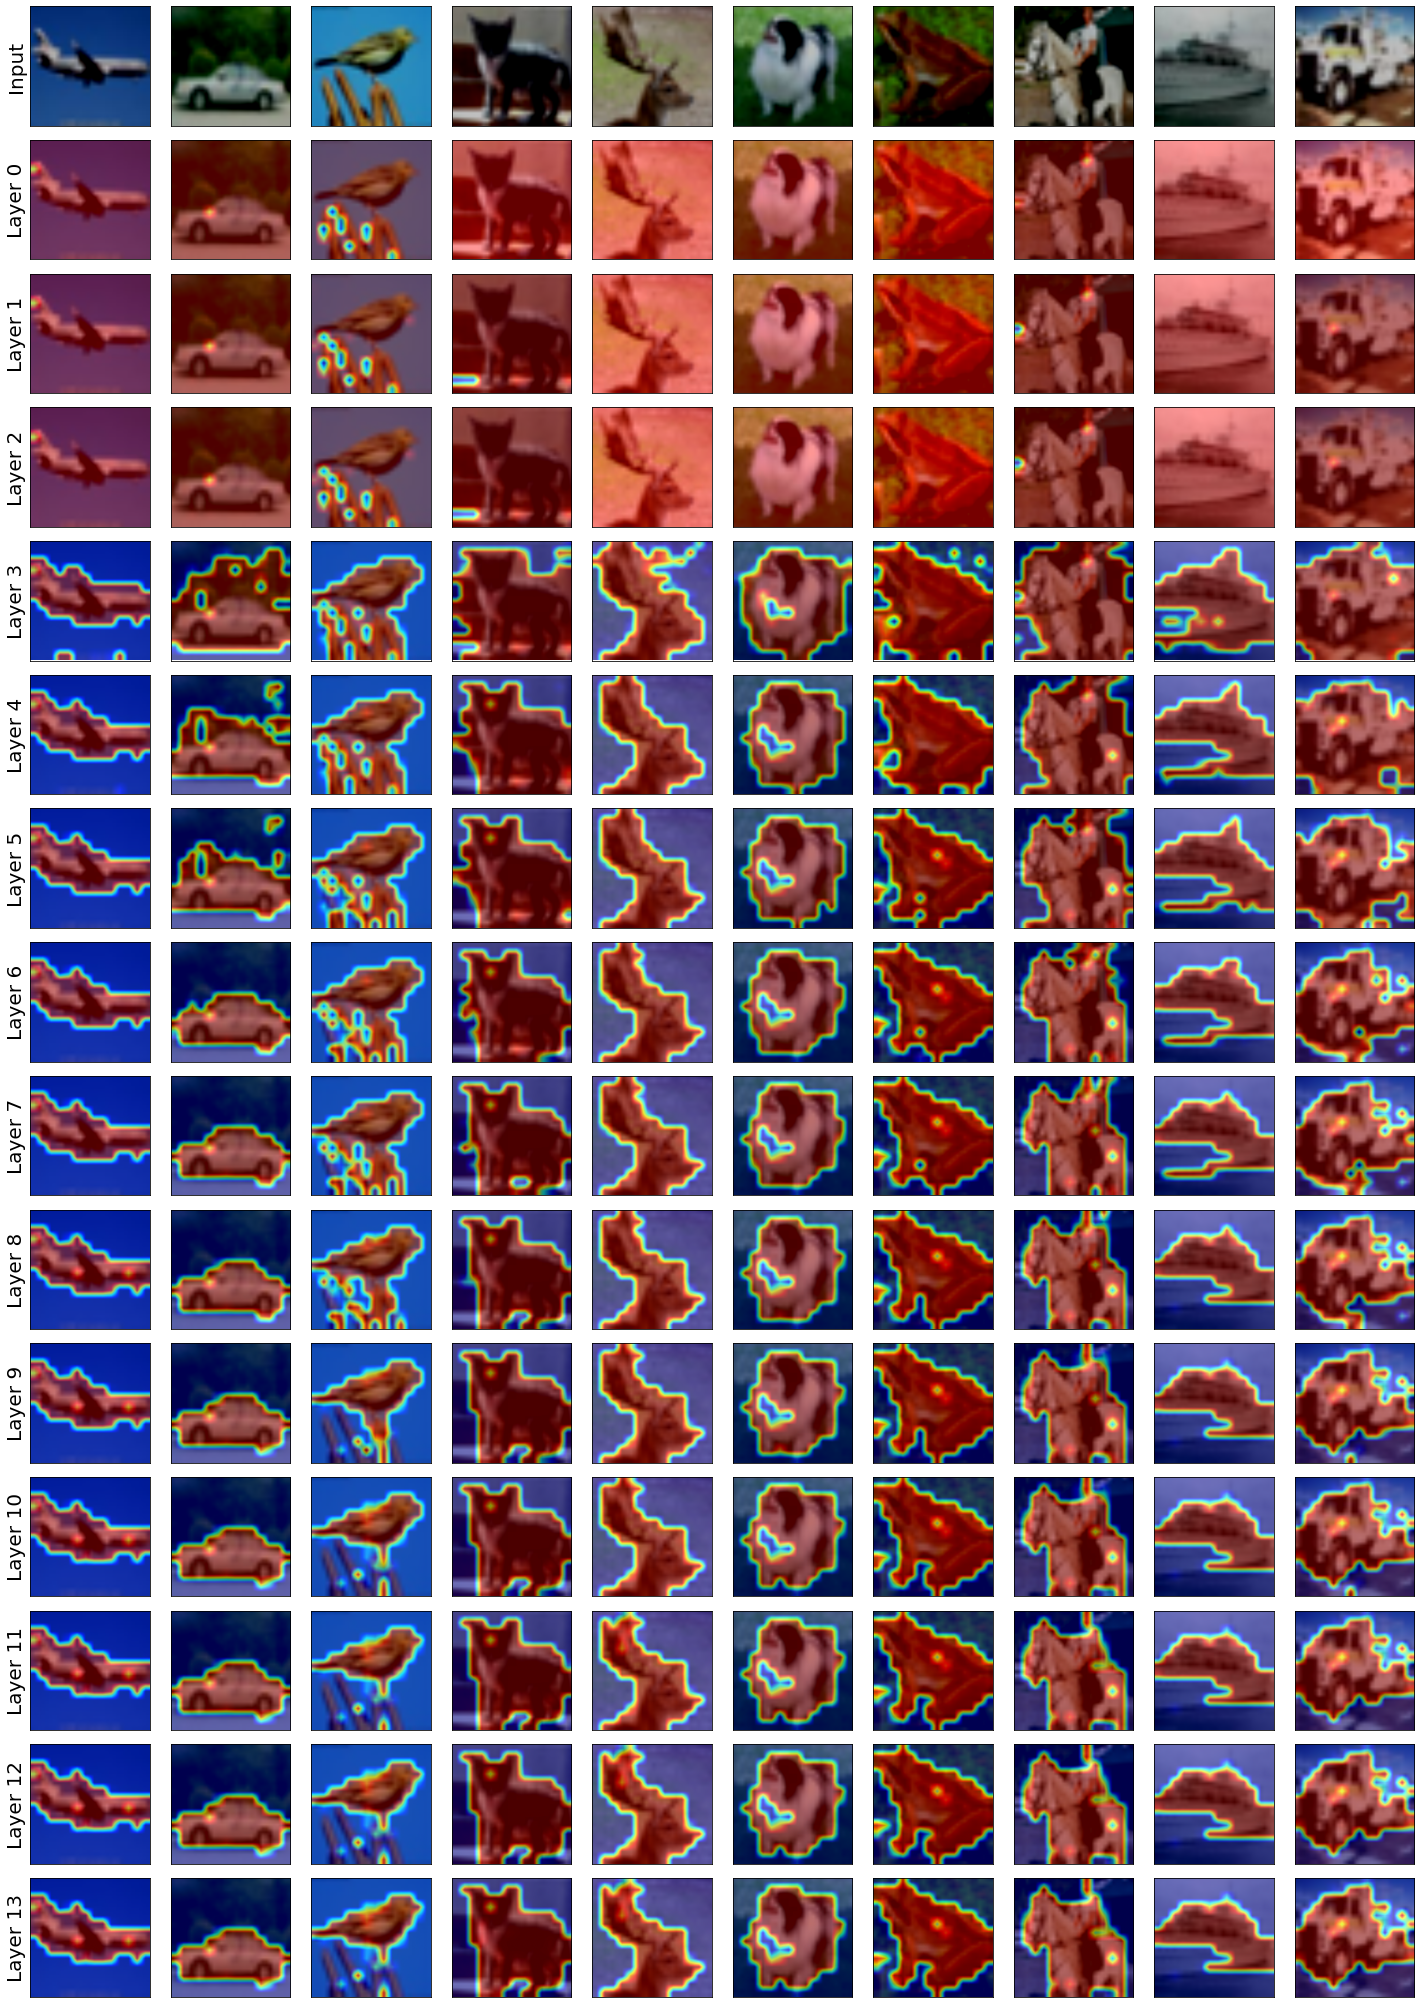

In [5]:
# aggregated masks
visualize(aggregated=True, save=True, name='aggregated_masks')

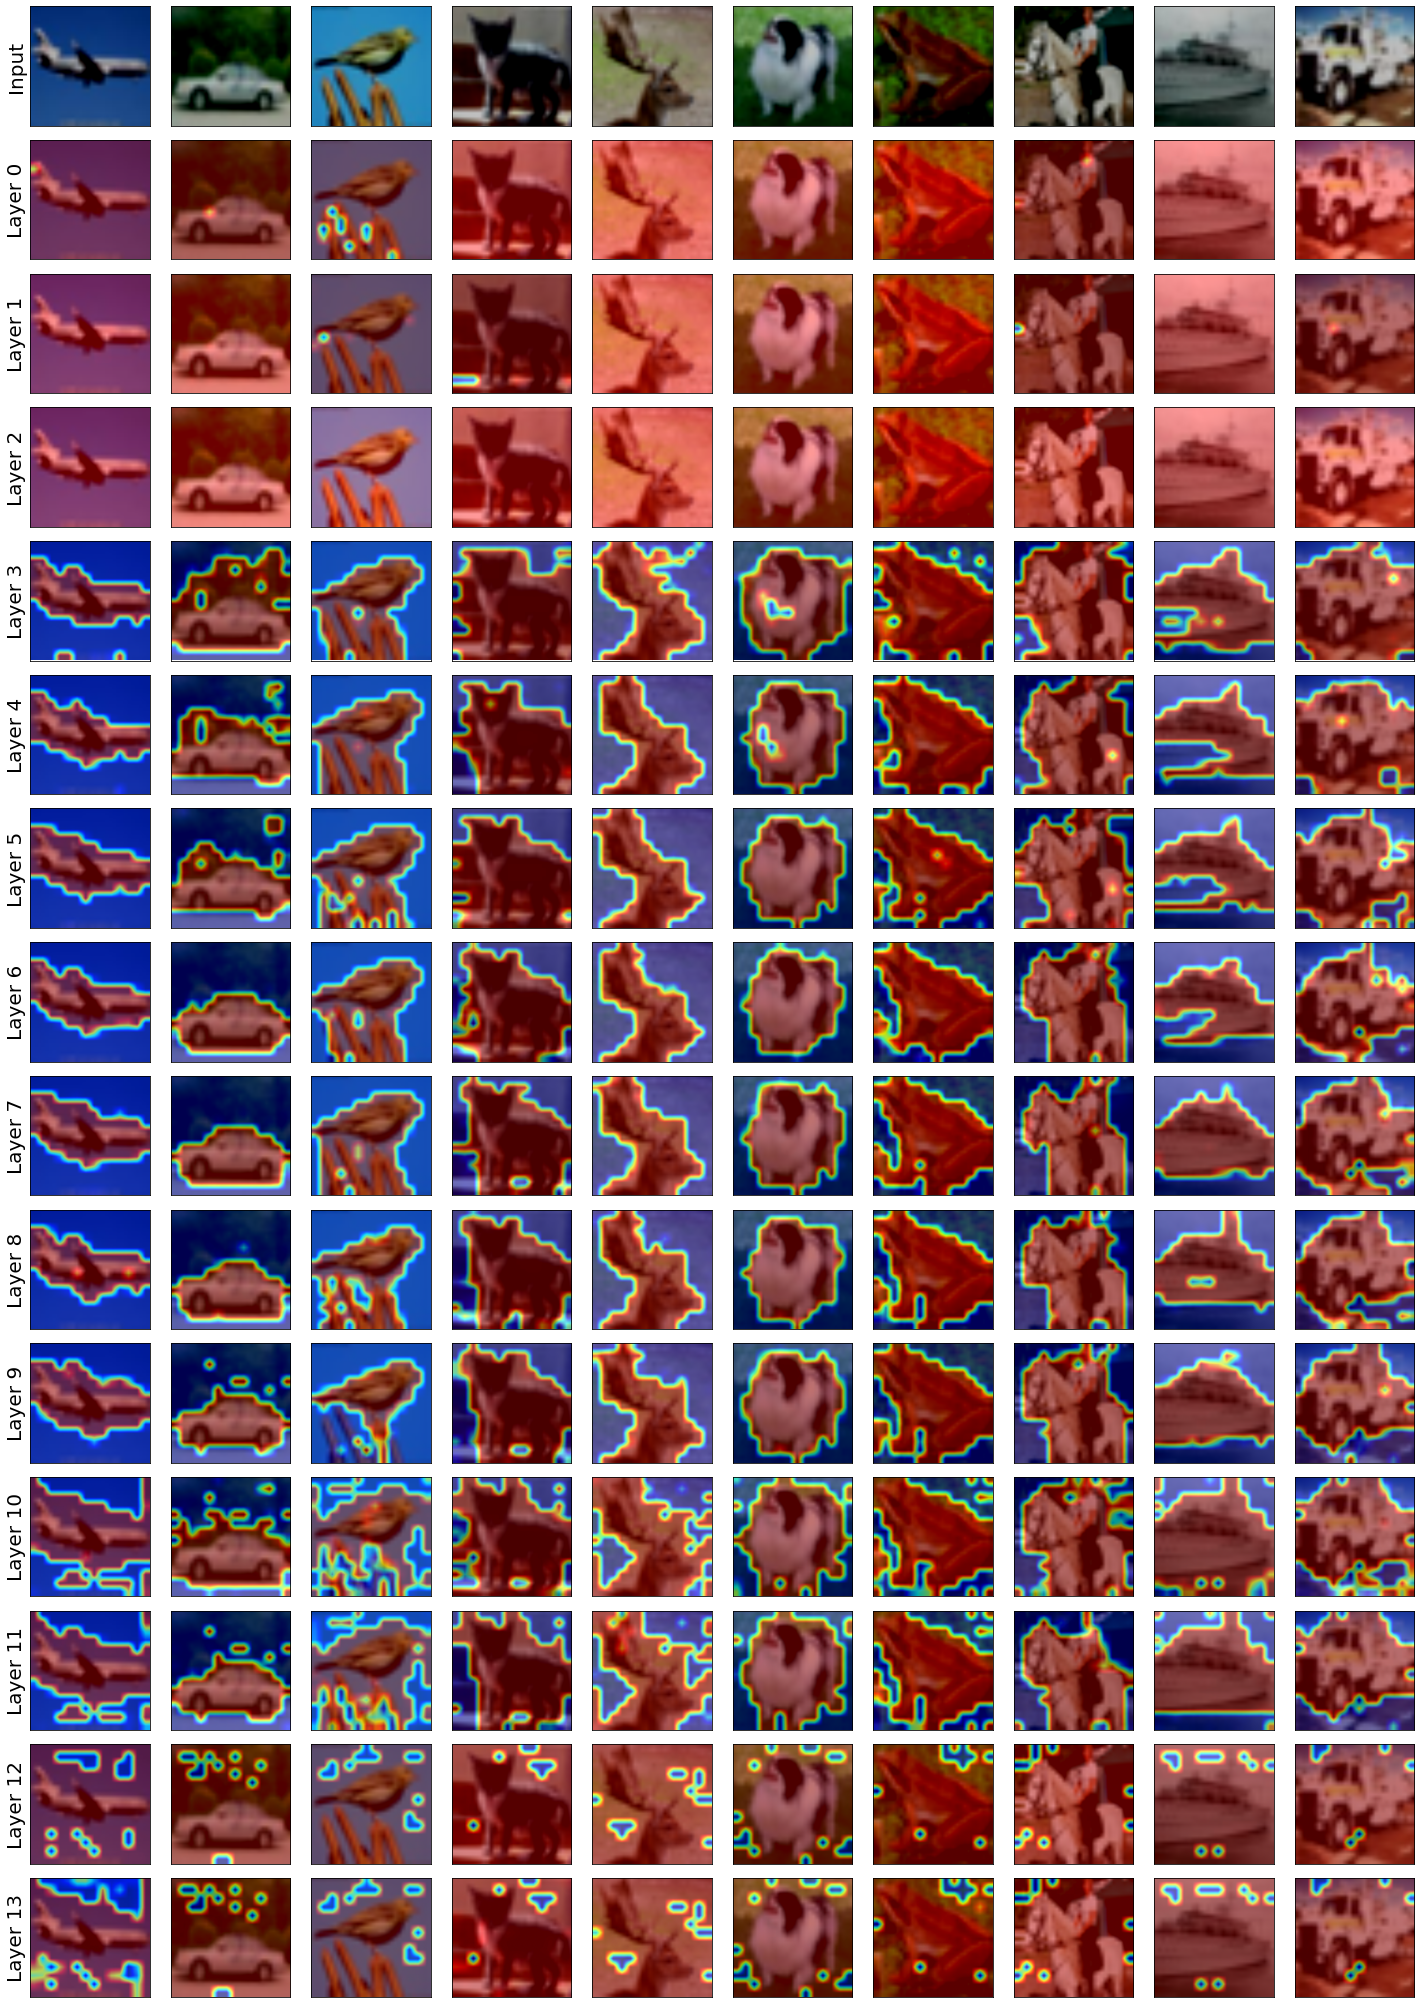

In [6]:
# non-aggregated masks
visualize(aggregated=False, save=True, name='non-aggregated_masks')